In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC #LinearSVC should scale better to a higher number of samples than SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, Bidirectional
from keras.utils import np_utils
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import XLNetTokenizer, TFXLNetModel
from scipy.stats import pearsonr

pd.set_option('display.max_colwidth', 50)


In [2]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# Load the spaCy language model for European Portuguese
#nlp = Portuguese()

In [3]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check

In [4]:
#load dataset
df = pd.read_csv("Final_preprocessed_dataset_portuguese.csv")
#df.fillna('', inplace=True)

In [5]:
check(df)

,column,dtypes,nunique,sum_null
0,Text,object,52283,0
1,Source,object,3101,13003
2,URL,object,63235,0
3,Label,int64,2,0
4,text_preprocessed,object,52246,0
5,count_words_text,int64,1459,0
6,num_nouns_text,int64,530,0
7,num_verbs_text,int64,408,0
8,num_adj_text,int64,311,0
9,num_adv_text,int64,153,0


Grid Search with TF-IDF only

In [6]:
tfidf = TfidfVectorizer(ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(df['features'])

Split the Data into training and testing datasets

In [7]:
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [8]:
results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

Grid Search of Decision Trees

In [8]:
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],  # Split criterion
    'max_features': ['auto', 'sqrt', 'log2', None]  # Number of features to consider at each split
}

In [9]:
# Grid search for Decision Trees
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                               param_grid=param_grid_dt,
                               scoring='f1_macro',
                               cv=5,
                               verbose=1,
                               n_jobs=-1)

# Perform grid search for Decision Trees
grid_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1_macro', verbose=1)

In [10]:
grid_search_dt_score_df = pd.DataFrame(grid_search_dt.cv_results_)
grid_search_dt_score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,330.242451,5.026827,2.084243,1.405976,gini,None,auto,1,2,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.799461,0.797331,0.795887,0.814346,0.794992,0.800403,0.007133,81
1,296.885222,8.213014,1.669794,0.177305,gini,None,auto,1,5,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.801837,0.803806,0.801739,0.821093,0.799920,0.805679,0.007805,77
2,277.231916,8.889036,2.030754,0.172299,gini,None,auto,1,10,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.808953,0.802826,0.806749,0.833425,0.803781,0.811147,0.011349,73
3,83.651585,17.784526,1.850713,0.800754,gini,None,auto,2,2,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.775285,0.773462,0.781654,0.803899,0.766658,0.780192,0.012780,95
4,68.581900,2.633253,0.983417,0.209614,gini,None,auto,2,5,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.777849,0.770297,0.779472,0.807021,0.782999,0.783528,0.012458,87


In [11]:
grid_search_dt_score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
99,2396.356725,12.299164,1.028757,0.241313,gini,20,None,1,2,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.951467,0.950676,0.948603,0.945729,0.945828,0.948461,0.002382,1
101,2320.221532,20.534120,0.815064,0.231184,gini,20,None,1,10,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.950183,0.950677,0.947022,0.946620,0.945927,0.948086,0.001952,2
100,2402.743499,14.626531,0.936247,0.170737,gini,20,None,1,5,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.950480,0.949689,0.947614,0.946520,0.945928,0.948046,0.001768,3
248,2539.559059,26.479850,0.912800,0.069904,entropy,20,None,2,10,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.950877,0.947507,0.946728,0.949582,0.944238,0.947786,0.002305,4
245,2478.313735,26.721336,1.054360,0.291501,entropy,20,None,1,10,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.950976,0.946815,0.947418,0.948789,0.944634,0.947726,0.002106,5


In [13]:
grid_search_dt.best_estimator_

DecisionTreeClassifier(max_depth=20, random_state=42)

In [14]:
dt_best = grid_search_dt.best_estimator_

Decision Trees:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      6285
           1       0.96      0.93      0.95      6363

    accuracy                           0.95     12648
   macro avg       0.95      0.95      0.95     12648
weighted avg       0.95      0.95      0.95     12648


----------------------Confusion Matrix---------------------- 



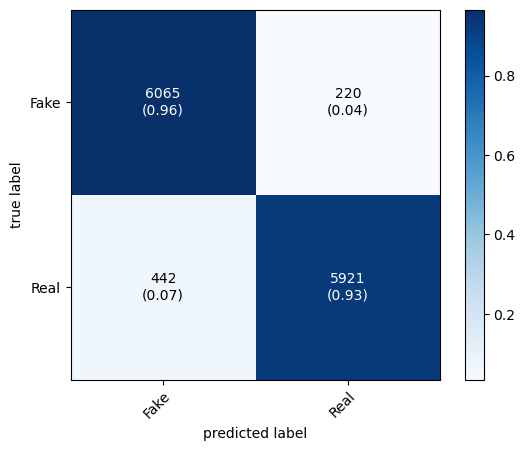

In [36]:
dt_report = classification_report(y_test, dt_best.predict(X_test))
accuracy = accuracy_score(y_test, dt_best.predict(X_test))

print("Decision Trees:")
print(dt_report)

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, dt_best.predict(X_test))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, dt_best.predict(X_test), average='macro')

results_df.loc[0] = ['Decision Trees',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

In [28]:
top_5_dt_df = grid_search_dt_score_df.nlargest(5,"mean_test_score")
top_5_dt_df.to_csv("Grid Search Decision Trees.csv")
print(top_5_dt_df)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
99     2396.356725     12.299164         1.028757        0.241313   
101    2320.221532     20.534120         0.815064        0.231184   
100    2402.743499     14.626531         0.936247        0.170737   
248    2539.559059     26.479850         0.912800        0.069904   
245    2478.313735     26.721336         1.054360        0.291501   

    param_criterion param_max_depth param_max_features param_min_samples_leaf  \
99             gini              20               None                      1   
101            gini              20               None                      1   
100            gini              20               None                      1   
248         entropy              20               None                      2   
245         entropy              20               None                      1   

    param_min_samples_split  \
99                        2   
101                      10   
100  

Grid search of XGBoost

In [16]:
param_grid_xgb = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting trees
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for fitting trees
}

In [17]:
# Grid search for Decision Trees
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42),
                               param_grid=param_grid_xgb,
                               scoring='f1_macro',
                               cv=5,
                               verbose=1,
                               n_jobs=-1)

# Perform grid search for Decision Trees
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='f1_macro', verbose=1)

In [18]:
grid_search_xgb_score_df = pd.DataFrame(grid_search_xgb.cv_results_)
grid_search_xgb_score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,959.933681,14.291768,3.621716,2.022817,0.8,0.01,3,100,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.920912,0.923074,0.927634,0.921996,0.921167,0.922957,0.002458,241
1,976.555191,19.696976,3.227154,1.131643,0.8,0.01,3,100,0.9,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.920912,0.923074,0.924684,0.921996,0.921167,0.922367,0.001383,243
2,997.083520,20.974425,3.466188,0.724088,0.8,0.01,3,100,1.0,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.921009,0.925429,0.926456,0.924741,0.920969,0.923721,0.002296,236
3,1896.742218,31.435744,2.843839,0.703938,0.8,0.01,3,200,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.925037,0.926118,0.928029,0.925427,0.925001,0.925923,0.001128,227
4,1921.956441,27.029407,5.153854,2.876813,0.8,0.01,3,200,0.9,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.925234,0.926018,0.927931,0.925427,0.924901,0.925902,0.001078,228


In [19]:
grid_search_xgb_score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
80,3154.711726,11.317353,2.422495,0.429761,0.8,0.2,5,300,1.0,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.957099,0.957689,0.955917,0.956502,0.955908,0.956623,0.000691,1
242,2287.869692,46.832691,0.482542,0.084436,1.0,0.2,5,300,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.957296,0.958184,0.955223,0.955413,0.956105,0.956444,0.001134,2
159,3344.817043,35.220130,2.003323,0.361909,0.9,0.2,5,300,0.8,"{'colsample_bytree': 0.9, 'learning_rate': 0.2...",0.957398,0.957395,0.955820,0.954821,0.955316,0.956150,0.001066,3
232,2250.293040,21.858113,1.667836,0.384484,1.0,0.2,4,300,0.9,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.956406,0.955416,0.955718,0.956996,0.956008,0.956109,0.000551,4
78,3105.553500,34.883651,2.702822,0.633852,0.8,0.2,5,300,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.957298,0.956506,0.955325,0.955613,0.955712,0.956091,0.000719,5


In [20]:
grid_search_xgb.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [21]:
xgb_best = grid_search_xgb.best_estimator_

XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6285
           1       0.97      0.94      0.95      6363

    accuracy                           0.96     12648
   macro avg       0.96      0.96      0.96     12648
weighted avg       0.96      0.96      0.96     12648


----------------------Confusion Matrix---------------------- 



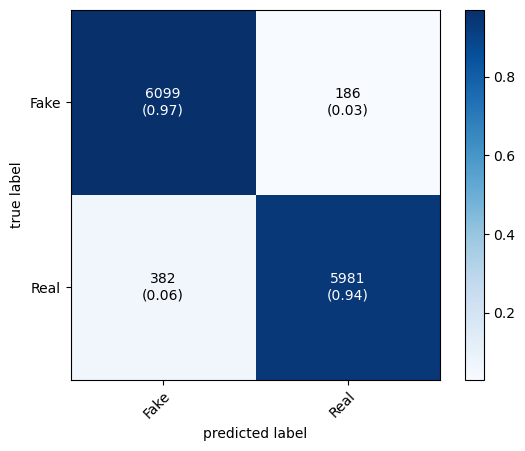

In [38]:
xgb_report = classification_report(y_test, xgb_best.predict(X_test))
accuracy = accuracy_score(y_test, xgb_best.predict(X_test))

print("XGBoost:")
print(xgb_report)

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, xgb_best.predict(X_test))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, xgb_best.predict(X_test), average='macro')

results_df.loc[1] = ['XGBoost',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

In [26]:
top_5_xlgb_df = grid_search_xgb_score_df.nlargest(5,"mean_test_score")
top_5_xlgb_df.to_csv("Grid Search XGBoost.csv")
print(top_5_xlgb_df)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
80     3154.711726     11.317353         2.422495        0.429761   
242    2287.869692     46.832691         0.482542        0.084436   
159    3344.817043     35.220130         2.003323        0.361909   
232    2250.293040     21.858113         1.667836        0.384484   
78     3105.553500     34.883651         2.702822        0.633852   

    param_colsample_bytree param_learning_rate param_max_depth  \
80                     0.8                 0.2               5   
242                    1.0                 0.2               5   
159                    0.9                 0.2               5   
232                    1.0                 0.2               4   
78                     0.8                 0.2               5   

    param_n_estimators param_subsample  \
80                 300             1.0   
242                300             1.0   
159                300             0.8   
232                3

In [39]:
results_df.to_csv("Grid Search text only results.csv", index=False)

Grid search of Logistic Regression (CONTINUE HERE)

In [9]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Type of penalty (L1 or L2)
    'max_iter': [100, 300, 500],  # Maximum number of iterations
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Algorithm to use in optimization
}

In [11]:
# Grid search for Logistic Regression
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42),
                               param_grid=param_grid_lr,
                               scoring='f1_macro',
                               cv=5,
                               verbose=1,
                               n_jobs=6)

# Perform grid search for Logistic Regression
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packa

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=6,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 300, 500], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs', 'saga']},
             scoring='f1_macro', verbose=1)

In [12]:
grid_search_lr_score_df = pd.DataFrame(grid_search_lr.cv_results_)
grid_search_lr_score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,12.581026,0.264080,0.332493,0.090664,0.01,100,l1,liblinear,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l1', ...",0.332806,0.332806,0.332806,0.332828,0.332828,0.332815,0.000011,73
1,0.937023,0.184541,0.000000,0.000000,0.01,100,l1,lbfgs,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l1', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,76
2,48.370605,7.622827,0.264123,0.038986,0.01,100,l1,saga,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l1', ...",0.333860,0.333860,0.333860,0.332828,0.333838,0.333649,0.000411,70
3,29.811787,1.667534,0.211175,0.039469,0.01,100,l2,liblinear,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...",0.873532,0.875700,0.879184,0.877192,0.869804,0.875082,0.003223,61
4,206.395176,22.300125,0.771981,0.272452,0.01,100,l2,lbfgs,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...",0.873636,0.875211,0.878891,0.877295,0.869314,0.874869,0.003303,67


In [13]:
grid_search_lr_score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
86,4486.382151,33.818215,0.121946,0.015263,100,500,l1,saga,"{'C': 100, 'max_iter': 500, 'penalty': 'l1', '...",0.953844,0.953150,0.951966,0.950676,0.951664,0.952260,0.001118,1
80,3681.422642,50.534119,0.116218,0.015311,100,300,l1,saga,"{'C': 100, 'max_iter': 300, 'penalty': 'l1', '...",0.954041,0.952951,0.951768,0.950083,0.951861,0.952141,0.001321,2
54,94.010654,21.366787,0.762502,0.298498,10,100,l1,liblinear,"{'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...",0.953942,0.950777,0.950879,0.953246,0.949488,0.951666,0.001663,3
60,85.282007,12.895154,0.846876,0.349312,10,300,l1,liblinear,"{'C': 10, 'max_iter': 300, 'penalty': 'l1', 's...",0.953942,0.950777,0.950879,0.953246,0.949488,0.951666,0.001663,3
66,90.050642,12.266817,0.796875,0.270453,10,500,l1,liblinear,"{'C': 10, 'max_iter': 500, 'penalty': 'l1', 's...",0.953942,0.950777,0.950879,0.953246,0.949488,0.951666,0.001663,3


In [14]:
grid_search_lr.best_estimator_

LogisticRegression(C=100, max_iter=500, penalty='l1', random_state=42,
                   solver='saga')

In [15]:
lr_best = grid_search_lr.best_estimator_

Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6285
           1       0.96      0.94      0.95      6363

    accuracy                           0.95     12648
   macro avg       0.95      0.95      0.95     12648
weighted avg       0.95      0.95      0.95     12648


----------------------Confusion Matrix---------------------- 



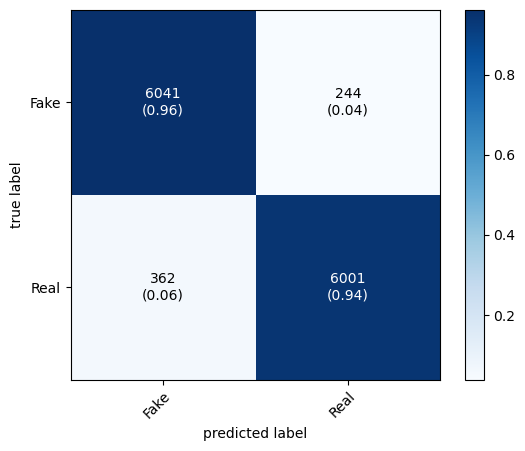

In [16]:
lr_report = classification_report(y_test, lr_best.predict(X_test))
accuracy = accuracy_score(y_test, lr_best.predict(X_test))

print("Logistic Regression:")
print(lr_report)

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, lr_best.predict(X_test))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, lr_best.predict(X_test), average='macro')

results_df.loc[2] = ['Logistic Regression',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

Grid search of Linear SVC

In [9]:
param_grid_lsvc = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l1', 'l2'],
    'max_iter': [700, 1000, 1300],
    'dual': [True, False]
}

In [10]:
# Grid search for Linear SVC
grid_search_lsvc = GridSearchCV(LinearSVC(random_state=42),
                               param_grid=param_grid_lsvc,
                               scoring='f1_macro',
                               cv=5,
                               verbose=1,
                               n_jobs=6)

# Perform grid search for Linear SVC
grid_search_lsvc.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-pac

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=6,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'dual': [True, False],
                         'max_iter': [700, 1000, 1300],
                         'penalty': ['l1', 'l2']},
             scoring='f1_macro', verbose=1)

In [11]:
grid_search_lsvc_score_df = pd.DataFrame(grid_search_lsvc.cv_results_)
grid_search_lsvc_score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_dual,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.670829,0.014131,0.0,0.0,0.01,True,700,l1,"{'C': 0.01, 'dual': True, 'max_iter': 700, 'pe...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
1,0.578286,0.074201,0.0,0.0,0.01,True,700,l2,"{'C': 0.01, 'dual': True, 'max_iter': 700, 'pe...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
2,0.541341,0.019472,0.0,0.0,0.01,True,1000,l1,"{'C': 0.01, 'dual': True, 'max_iter': 1000, 'p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
3,0.578393,0.031763,0.0,0.0,0.01,True,1000,l2,"{'C': 0.01, 'dual': True, 'max_iter': 1000, 'p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
4,0.563262,0.007552,0.0,0.0,0.01,True,1300,l1,"{'C': 0.01, 'dual': True, 'max_iter': 1300, 'p...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,16


In [12]:
grid_search_lsvc_score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_dual,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
55,4399.154996,1607.233896,1.158800,0.454418,100,False,700,l2,"{'C': 100, 'dual': False, 'max_iter': 700, 'pe...",0.949199,0.948109,0.947913,0.942372,0.946326,0.946784,0.002389,1
57,4718.456464,1333.899802,1.055026,0.722650,100,False,1000,l2,"{'C': 100, 'dual': False, 'max_iter': 1000, 'p...",0.949199,0.948109,0.947913,0.942372,0.946326,0.946784,0.002389,1
59,2462.677600,996.115712,0.668421,0.324760,100,False,1300,l2,"{'C': 100, 'dual': False, 'max_iter': 1300, 'p...",0.949199,0.948109,0.947913,0.942372,0.946326,0.946784,0.002389,1
43,3202.145163,1613.405558,1.166639,0.265526,10,False,700,l2,"{'C': 10, 'dual': False, 'max_iter': 700, 'pen...",0.944750,0.945046,0.945244,0.939703,0.942273,0.943403,0.002139,4
45,3324.253015,1441.384065,1.155879,0.433875,10,False,1000,l2,"{'C': 10, 'dual': False, 'max_iter': 1000, 'pe...",0.944750,0.945046,0.945244,0.939703,0.942273,0.943403,0.002139,4


In [13]:
grid_search_lsvc.best_estimator_

LogisticRegression(C=100, max_iter=700, random_state=42)

In [14]:
lsvc_best = grid_search_lsvc.best_estimator_

Linear SVC:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6285
           1       0.96      0.94      0.95      6363

    accuracy                           0.95     12648
   macro avg       0.95      0.95      0.95     12648
weighted avg       0.95      0.95      0.95     12648


----------------------Confusion Matrix---------------------- 



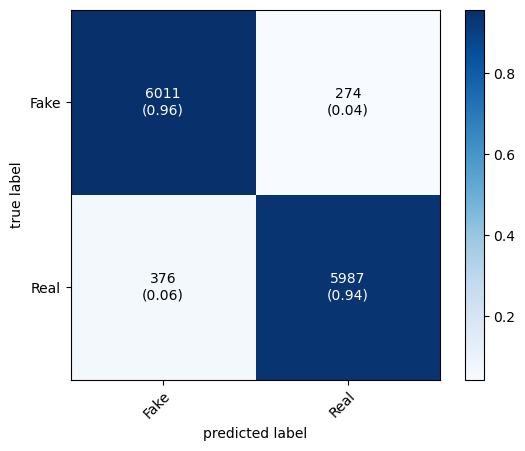

In [15]:
lsvc_report = classification_report(y_test, lsvc_best.predict(X_test))
accuracy = accuracy_score(y_test, lsvc_best.predict(X_test))

print("Linear SVC:")
print(lsvc_report)

print("\n----------------------Confusion Matrix---------------------- \n")
conf_mat = confusion_matrix(y_test, lsvc_best.predict(X_test))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])
plt.show()

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, lsvc_best.predict(X_test), average='macro')

results_df.loc[3] = ['Linear SVC',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

In [ ]:
results_df.to_csv("Grid Search TFIDF features results 2.csv", index=False)